(4, 3060)
(3060,)


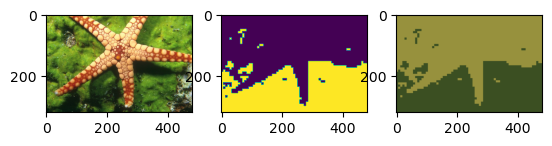

In [7]:
# CS5487 demo script for Programming Assignment 2
#
# The script has been tested with python 2.7.6
#
# It requires the following modules:
#   numpy 1.8.1
#   matplotlib v1.3.1
#   scipy 0.14.0
#   Image (python image library)

import pa2
import numpy as np
import pylab as pl
from PIL import Image
import scipy.io as sio

def demo():
    import scipy.cluster.vq as vq

    ## load and show image
    img = Image.open('images/12003.jpg')
    pl.subplot(1,3,1)
    pl.imshow(img)
    
    ## extract features from image (step size = 7)
    X,L = pa2.getfeatures(img, 7)

    print(X.shape)
    ## Call kmeans function in scipy.  You need to write this yourself!
    C,Y = vq.kmeans2(vq.whiten(X.T), 2, iter=1000, minit='random')
    Y = Y + 1 # Use matlab 1-index labeling
    print(Y.shape)
    ## 

    # make segmentation image from labels
    segm = pa2.labels2seg(Y,L)
    pl.subplot(1,3,2)
    pl.imshow(segm)
    
    # color the segmentation image
    csegm = pa2.colorsegms(segm, img)
    pl.subplot(1,3,3)
    pl.imshow(csegm)
    pl.show()

def main():
    demo()
if __name__ == '__main__':
    main()


In [10]:
from collections import Counter


point = np.loadtxt('./cluster_data_text/cluster_data_dataA_X.txt')
True_label = np.loadtxt('./cluster_data_text/cluster_data_dataA_Y.txt')
Counter(True_label)
print(point.shape)

(2, 200)


In [54]:
import json
import scipy.cluster.vq as vq

In [78]:
def loadData(datafile:str, problem:str, img=None):
    if problem == 'a':
        X = np.loadtxt('./cluster_data_text/{}.txt'.format(datafile))
        print(X.shape)
        return X
    else :
        ## extract features from image (step size = 7)
        X,L = pa2.getfeatures(img, 7)
        X = vq.whiten(X.T).T
        return X, L

In [488]:
def dist(X, C, i, scale=0, lbda=0):
    if scale==0:
        return np.linalg.norm(X - C[:, i].reshape(-1, 1), axis=0)**2
    else:
        return np.linalg.norm(X[:2] - C[:2, i].reshape(-1, 1) , axis=0)**2 + lbda * np.linalg.norm(X[2:4] - C[2:4, i].reshape(-1, 1) , axis=0)**2

        
def Kmeans(X, K, iter=1000, sensitivity=0.00001, scale=0, lbda=0):
    # X: data D * N
    # K: number of clusters
    # return: labels, centroids
    # randomly initialize centroids
    D, N = X.shape
    C = X[:, np.random.choice(N, K, replace=False)]
    Y = np.zeros(N)
    for j in range(iter):
        # calculate distance
        distance = np.zeros((K, N))
        for i in range(K):
            distance[i, :] = dist(X, C, i, scale=scale, lbda=lbda)
        # assign labels
        Y = np.argmin(distance, axis=0)
        # update centroids
        C_new = np.zeros((D, K))
        for i in range(K):
            C_new[:, i] = np.mean(X[:, Y == i], axis=1)
        # check convergence
        if np.sum((C_new - C) ** 2) < sensitivity:
            break
        C = C_new
    return Y, C



In [128]:
x = np.array([np.identity(2) for i in range(9)])
x.shape


(9, 2, 2)

In [489]:
import math

def init_data(sample, K): 
    Pi = (1/K)*np.ones(K) 
    X = sample
    mu = np.random.random((X.shape[0], K))
    Cov_mat = np.array([np.identity(X.shape[0]) for i in range(K)])
    print(Cov_mat.shape)
    respon = np.zeros((X.shape[1],K))  
    return X, Pi, mu, Cov_mat, respon



def E_step(X, Pi, mu, Cov_mat, respon, K):   
    N = X.shape[1]
    for i in range(N):
        Numer = np.zeros((1,K))
        Denom = 0 
        for j in range(K):
            Numer[:,j] = Pi[j] * math.exp(-1/2 * (X[:,i] - mu[:,j]).T @ np.linalg.inv(Cov_mat[j])@(X[:,i] - mu[:,j])) / math.sqrt(2*math.pi*np.linalg.det(Cov_mat[j]))
        respon[i, :] = Numer / np.sum(Numer, axis=1) 
    return respon
    
    
def M_step(X, Pi, mu, Cov_mat, respon, K):  
    N = X.shape[1]
    for j in range(K):  
        Numer = 0  
        Denom = 0  
        for i in range(N):  
            Numer += respon[i,j] * X[:,i]  
            Denom += respon[i,j]  
        mu[:,j] = Numer / Denom
        Pi[j] = Denom / N
        Cov_mat[j] = np.zeros((X.shape[0], X.shape[0]))
        for i in range(N):
            Cov_mat[j] += respon[i,j] * (X[:,i] - mu[:,j]).reshape(-1,1) @ (X[:,i] - mu[:,j]).reshape(1,-1)
        Cov_mat[j] /= Denom
    return Pi, mu, Cov_mat
        
def EM_model(sample, K, iter=1000, sensitivity=0.00001):
    X, Pi, mu, Cov_mat, respon = init_data(sample,K)  
    N = X.shape[1]
    Y = np.zeros(N)
    old_mu = np.zeros((X.shape[0], K)) 
    for i in range(iter):   
        respon = E_step(X, Pi, mu, Cov_mat, respon, K)  
        Pi, mu, Cov_mat = M_step(X, Pi, mu, Cov_mat, respon, K)
        Y = np.argmax(respon, axis=1)
        if np.sum(mu-old_mu)**2 < sensitivity:
            break
        old_mu = mu.copy()
    return Y, mu, Cov_mat, Pi, respon

(2, 200)


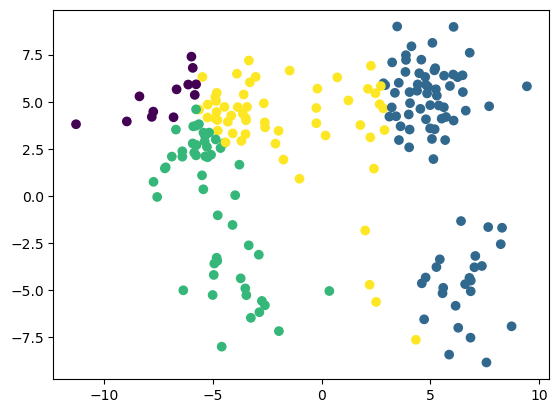

In [490]:
dataset = loadData('cluster_data_dataA_X', 'a')
Y, C = Kmeans(dataset, 4, 1)
import matplotlib.pyplot as plt
plt.scatter(dataset[0, :], dataset[1, :], c=Y)
plt.show()

(2, 200)
(4, 2, 2)


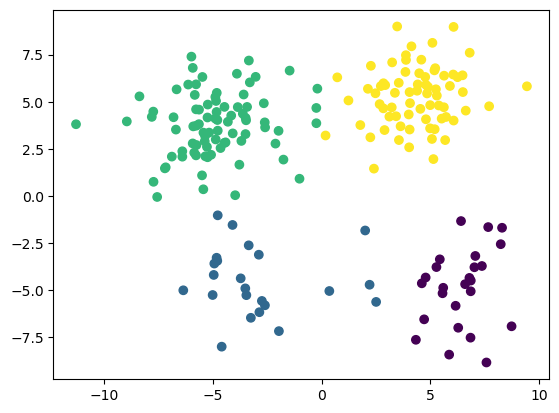

In [491]:
dataset = loadData('cluster_data_dataA_X', 'a')
Y, mu, Cov_mat, Pi, respon = EM_model(dataset, 4)
import matplotlib.pyplot as plt
plt.scatter(dataset[0, :], dataset[1, :], c=Y)
plt.show()

In [555]:
import copy

def KDE(X, x_t, i, hp, scale=0, hc=0):
    if scale ==0:
        return math.exp(-1/(2*hp**2) * (X[:,i].reshape(-1,1) - x_t).T @ (X[:,i].reshape(-1,1) - x_t)) / math.sqrt(2*math.pi* hp**2)
    else:
        return math.exp(-1/(2*hc**2) * (X[:2,i] - x_t[:2]).reshape(1,-1) @ (X[:2,i] - x_t[:2]).reshape(-1,1) -1/(2*hp**2) * (X[2:4,i] - x_t[2:4]).reshape(1,-1) @ (X[2:4,i] - x_t[2:4]).reshape(-1,1) ) / math.sqrt(2*math.pi* (hp**2)*(hc**2)) 

def Gussian_mean_shift(X, hp, hc=0, iter=1000, sensitivity=10e-6):
    # X: data D * N
    # h: bandwidth
    # return: labels, centroids
    D, N = X.shape
    Y = np.zeros(N)
    K = []
    # X = X.random()
    for j in range(N):
        C = X[:, j]
        C = np.expand_dims(C, axis=1)
        print(C.shape)
        for its in range(iter):
            Numer = np.zeros((D, 1))  
            Denom = 0
            for i in range(N):
                kde = KDE(X, C, i, hp)
                Numer += kde * X[:, i].reshape(-1,1)
                Denom += kde
            x_tnew = Numer/Denom
            # print(x_tnew.shape)
            if np.sum((x_tnew - C) ** 2) < sensitivity:
                break
            C = x_tnew.copy()
        # if len(K)==0:
        #     K.append(x_tnew)
        # dis = []
        # for k in range(len(K)):
        #     dis.append(np.linalg.norm(x_tnew - K[k]))
        # if np.min(dis) < 0.001:
        #     Y[j] = np.argmin(dis)
        # else:
        #     K.append(x_tnew)
        #     Y[j] = len(K)-1
        flag = True
        for k in range(len(K)):
            if (K[k] == np.round(C,2)).all():
                flag = False
                Y[j] = k
                break
        if flag:
            K.append(np.round(C,2))
            Y[j] = len(K)-1
    return Y


(2, 200)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 

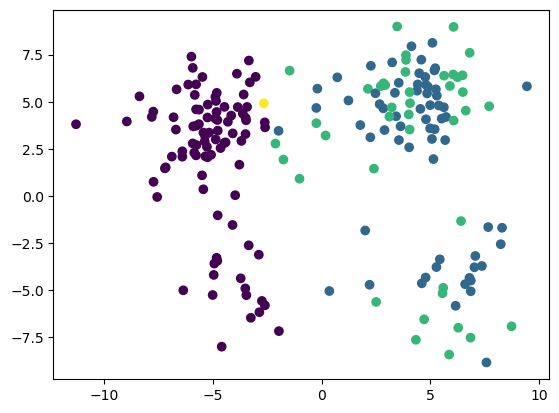

In [568]:
dataset = loadData('cluster_data_dataA_X', 'a')
Y = Gussian_mean_shift(dataset, 4.5)
Y = Y+1
print(Y.max())
import matplotlib.pyplot as plt
plt.scatter(dataset[0, :], dataset[1, :], c=Y)
plt.show()

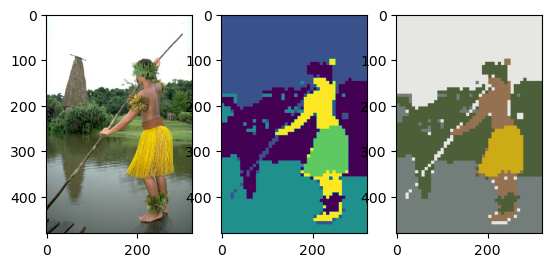

In [101]:


import pa2
import numpy as np
import pylab as pl
from PIL import Image
import scipy.io as sio
img = Image.open('images/101087.jpg')
pl.subplot(1,3,1)
pl.imshow(img)
dataset, L = loadData('101087', 'b', img=img)
Y, C = Kmeans(dataset, 5, scale=1, lbda=0.1)
Y = Y + 1
segm = pa2.labels2seg(Y,L)
pl.subplot(1,3,2)
pl.imshow(segm)

    # color the segmentation image
csegm = pa2.colorsegms(segm, img)
pl.subplot(1,3,3)
pl.imshow(csegm)
pl.show()
    